###  **최우추정법**

In [ ]:
# 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import normal

In [ ]:
# 파라미터 설정하기
N=10                 # 샘플을 취득하는 위치 x의 개수
M_list=[0,1,3,9]     # 그래프로 표현할 다항식의 차수

In [ ]:
# 데이터 셋 생성 함수(create_dataset) 선언하기
# 데이터셋 {x_n,y_n} (n=1...N))
def create_dataset(num):
    dataset = pd.DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale = 0.3)                 # scale은 standard deviation.
        dataset = dataset.append(pd.Series([x,y],index=['x','y']),  # pandas.DataFrame.append(): 새로운 객체 반환.
                                 ignore_index = True)               # index가 0, 1, ... 
    return dataset

In [ ]:
# 학습시킬 데이터 생성하기
train_set = create_dataset(N)

train_set

,x,y
0,0.000000,-0.293400
1,0.111111,0.640217
2,0.222222,1.015924
3,0.333333,0.931085
4,0.444444,0.317147
5,0.555556,-0.058394
6,0.666667,-0.781758
7,0.777778,-0.646977
8,0.888889,-0.553780
9,1.000000,-0.028660


Text(0.5, 1.0, 'dataset')

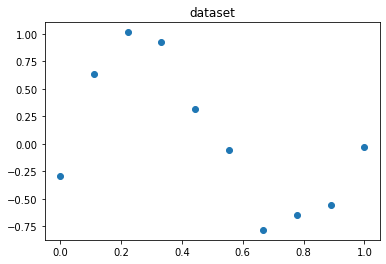

In [ ]:
# 트레인 데이터셋 출력
X = train_set['x'] # X는 pandas.core.series.Series 객체. 
Y = train_set['y'] # Y는 pandas.core.series.Series 객체. 

plt.scatter(X,Y)
plt.title('dataset')

In [ ]:
# M이 2이고, N = 10일 때 최우추정법으로 추정하기 (다항식의 w값 찾기) 

# 정규분포를 가정하였기 때문에, 최소제곱법(exercise02)과 동일한 방법으로 계산 가능함

# w: (3,1) matrix
# phi: (10,3) matrix
# wT * phiT * phi - tT * phi = 0
# w = inv(phiT * phi) * phiT * t

M = 2

t = train_set.y                           # {t}: (N, 1) matrix (vector)
phi = pd.DataFrame()
for i in range(0,M+1): 
    p = train_set.x**i
    p.name="x**%d" % i 
    phi = pd.concat([phi,p], axis=1)        # phi matrix에 새로운 column 추가. 

tmp = np.linalg.inv(np.dot(phi.T, phi))     # tmp = inv(phiT * phi)
w = np.dot(np.dot(tmp, phi.T), t)           # ws = inv(phiT * phi) * phiT * t

print("w is " + str(w.shape) + " matrix")
print(w)

w is (3,) matrix
[ 0.43009132  0.02783822 -1.10805147]


In [ ]:
# M이 2이고, N = 10일 때 최우추정법으로 추정하기 (표준편차(sigma)값 찾기) 

# 표준편차 계산
# sigma = (1/b)**0.5 = (2*Ed/N)**0.5 = Erms

def f(x,w):
    y = 0.0
    for i, w in enumerate(w):
        y += w * (x ** i)
    return y

sigma2 = 0.0  

for index, line in train_set.iterrows():
    x, y = line.x, line.y
    sigma2 += (f(x,w)-y)**2

sigma2 /= len(train_set)
sigma = np.sqrt(sigma2)

print("{:.2f}".format(sigma))

0.50


In [ ]:
# 최우추정법으로 계산하는 함수 선언하기
def resolve(dataset, m):
    t = dataset.y
    phi = pd.DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0.0
        for i, w in enumerate(ws):
          y += w * (x ** i)
        return y

    sigma2 = 0.0 
    for index, line in dataset.iterrows():
      sigma2 += (f(line.x)-line.y)**2
    sigma2 /= len(dataset)

    return (f, ws, np.sqrt(sigma2))

In [ ]:
# w matrix 구하기(다항식 차수에 따른 w 값들)
df_ws = pd.DataFrame()

for c, m in enumerate(range(N)):
    f, ws, sigma = resolve(train_set, m)
    df_ws = df_ws.append(pd.Series(ws,name="M=%d" % m))
pd.options.display.float_format = "{:,.2f}".format
print("Table of the coefficients")
df_ws

Table of the coefficients


,0,1,2,3,4,5,6,7,8,9
M=0,0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan
M=1,0.59,-1.08,nan,nan,nan,nan,nan,nan,nan,nan
M=2,0.43,0.03,-1.11,nan,nan,nan,nan,nan,nan,nan
M=3,-0.27,11.60,-31.62,20.34,nan,nan,nan,nan,nan,nan
M=4,-0.33,13.70,-42.19,37.29,-8.47,nan,nan,nan,nan,nan
M=5,-0.29,10.58,-16.17,-36.24,75.80,-33.71,nan,nan,nan,nan
M=6,-0.29,9.85,-7.22,-74.78,150.29,-99.97,22.09,nan,nan,nan
M=7,-0.29,12.67,-53.80,201.43,-630.73,"1,038.98",-804.45,236.15,nan,nan
M=8,-0.29,-2.07,243.59,"-2,041.62","7,831.08","-16,577.68","19,748.32","-12,347.18","3,145.83",nan
M=9,-0.29,99.93,"-2,112.66","19,182.27","-91,877.34","255,068.69","-425,061.60","419,095.59","-225,121.04","50,726.42"


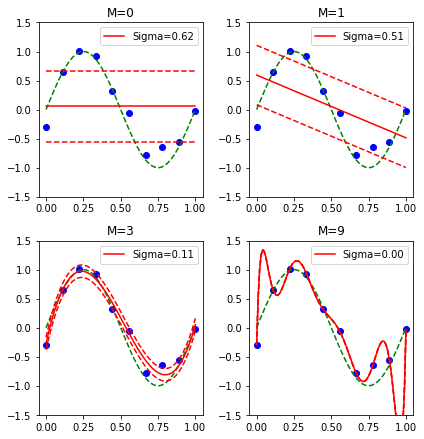

In [ ]:
# 최우추정법으로 다항식 근사치를 구한 결과 시각화 하기
fig_width = 3*2
fig_height = 3*(int(len(M_list)/2)+1)
fig = plt.figure(figsize = (fig_width, fig_height))

for c, M in enumerate(M_list):
    f, ws, sigma = resolve(train_set, M)
    df_ws = df_ws.append(pd.Series(ws,name="M=%d" % M))

    subplot = fig.add_subplot(int(len(M_list)/2)+1, 2, c+1)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % M)

    # 트레이닝 세트 표시
    subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')

    # sin곡선을 표시
    linex = np.linspace(0,1,101)    # numpy.ndarray (101,)
    liney = np.sin(2*np.pi*linex)   # numpy.ndarray (101,)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 근사 곡선 및 표준편차 표시
    linex = np.linspace(0,1,101)   # numpy.ndarray (101,)
    liney = f(linex)
    label = "Sigma=%.2f" % sigma
    subplot.plot(linex, liney, color='red', label=label)
    subplot.plot(linex, liney+sigma, color='red', linestyle='--')
    subplot.plot(linex, liney-sigma, color='red', linestyle='--')
    subplot.legend(loc=1)

fig.tight_layout()
fig.show()

In [ ]:
# 우도 계산하는 함수(log_likelihood) 선언하기
def log_likelihood(dataset, f):
    dev = 0.0                   # dev: deviation 
                                # sigma = (dev / N) ** 0.05            
    n = float(len(dataset))

    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        dev += (y - f(x))**2
    
    err = dev * 0.5             # err: Ed
    beta = n / dev
    lp = 0.5*n*np.log(beta) + 0.5*n*np.log(2*np.pi) - beta*err

    return lp

   Training set  Test set
0          9.02      6.25
1         10.89      8.31
2         11.08      7.91
3         26.52     14.84
4         27.89     14.63
5         29.61     14.73
6         29.65     14.70
7         29.86     14.67
8         31.01     14.72
9         85.81     14.66


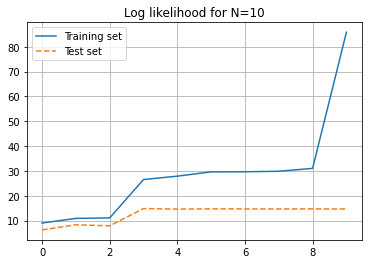

In [ ]:
# 트레이닝 셋과 테스트 셋에 대한 우도 시각화

df = pd.DataFrame()
test_set = create_dataset(N)

train_mlh = []
test_mlh = []
for m in range(0,9): 
    f, ws, sigma = resolve(train_set, m)
    train_mlh.append(log_likelihood(train_set, f))
    test_mlh.append(log_likelihood(test_set, f))

df = pd.concat([df,
                pd.DataFrame(train_mlh, columns=['Training set']),
                pd.DataFrame(test_mlh, columns=['Test set'])],
                axis=1)

print(df)
df.plot(title='Log likelihood for N=%d' % N, grid=True, style=['-','--'])